In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spk_values = {
    "m": {"mu": [5], "cov": [[1]]},
    "f": {"mu": [-5], "cov": [[1]]}
}
acc_values = {
    "a1": {"mu": [-5], "cov": [[1]]},
    "a2": {"mu": [5], "cov": [[1]]}
}

In [4]:
sample_dist = lambda values_dict : np.random.multivariate_normal(
    mean=values_dict["mu"],
    cov=values_dict["cov"]
)

In [5]:
spk_acc_probs = {
    "m": [1, 0],
    "f": [0, 1]
}

In [6]:
def get_embedding(spk_values: dict, acc_values: dict, prob_map: dict, mode: str = "joint"):
    spk = np.random.choice(list(spk_values.keys()))
    spk_embed = sample_dist(spk_values[spk])
    
    if mode == "joint":
        acc = np.random.choice(list(acc_values.keys()), p=prob_map[spk])
    elif mode == "marginal":
        acc = np.random.choice(list(acc_values.keys()))
    else:
        raise ValueError("mode must be in [joint, marginal]")
    acc_embed = sample_dist(acc_values[acc])
    
    combined_embed = np.concatenate([spk_embed, acc_embed])
    return combined_embed

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

/home/eml/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

def sample_batch(sv, av, batch_size=100, sample_mode='joint'):
    batch = np.array(
        [get_embedding(sv, av, spk_acc_probs, mode=sample_mode) for _ in range(batch_size)]
    )
    return batch

def train(sv, av, mine_net ,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3), verbose=True):
    # data is x or y
    result = list()
    batches = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(sv, av, batch_size=batch_size)\
        , sample_batch(sv, av, batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        batches.append(batch)
        if (i+1)%(log_freq)==0 and verbose:
            print(result[-1])
    return result, batches

def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [9]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor, batches_cor = train(spk_values, acc_values, mine_net_cor,mine_net_optim_cor)
result_cor_ma = ma(result_cor)

0.93720365
0.73770607
0.53961015
0.8197848
0.7074661


In [10]:
goal_mi = np.log(2)
est_mi = result_cor_ma[-1]

print(f"Goal MI: {goal_mi}")
print(f"Estimated MI: {est_mi}")

Goal MI: 0.6931471805599453
Estimated MI: 0.6766616702079773


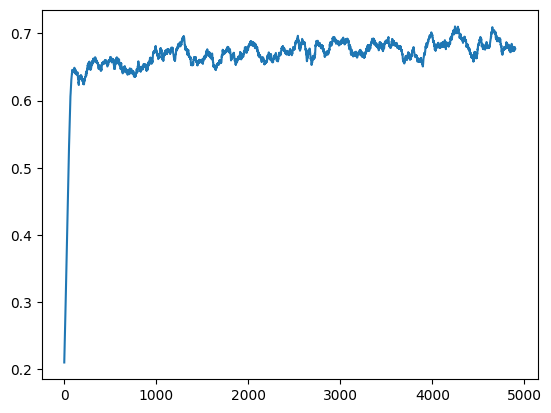

In [11]:
plt.plot(range(len(result_cor_ma)),result_cor_ma)

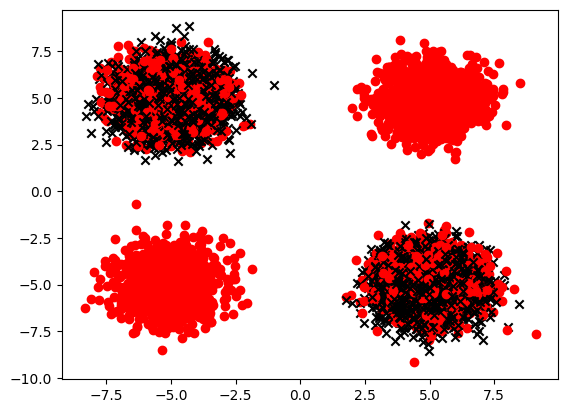

In [12]:
for batch in batches_cor[:50]:
    joint, marginal = batch
    plt.scatter(marginal[:, 0], marginal[:, 1], c="r")
    plt.scatter(joint[:, 0], joint[:, 1], marker="x", c="k")

In [13]:
from tqdm import tqdm

results = []
covs = np.linspace(0, 5, 1000)
for COV in tqdm(covs):
    spk_val = {
        "m": {"mu": [5], "cov": [[COV]]},
        "f": {"mu": [-5], "cov": [[COV]]}
    }
    acc_val = {
        "a1": {"mu": [-5], "cov": [[COV]]},
        "a2": {"mu": [5], "cov": [[COV]]}
    }
    
    mine_net_cor = Mine().cuda()
    mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
    result_cor, batches_cor = train(spk_val, acc_val, mine_net_cor,mine_net_optim_cor, batch_size=10, verbose=False)
    result_cor_ma = ma(result_cor)
    results.append(result_cor_ma[-1])
    del mine_net_cor
    del mine_net_optim_cor

 13%|█▎        | 134/1000 [39:19<4:12:22, 17.49s/it]

In [ ]:
plt.plot(results, c="r")
plt.axhline(np.log(2), c="k", ls="--")

NameError: name 'plt' is not defined